# 吴恩达深度学习课程作业L2W5

* Improving Deep Neural Networks
* 加强深度网络性能的一些技巧
* 参数初始化技巧
* 正则化技巧，l2, dropout
* 梯度检验

## HW参考

1. [视频链接](https://mooc.study.163.com/university/deeplearning_ai#/c)
2. [作业链接](https://github.com/suqi/deeplearning_andrewng/tree/master/Course2-DL-tuning/week5)

## 注意使用numpy的问题：

1. [RuntimeWarning: divide by zero encountered in log](https://stackoverflow.com/questions/21610198/runtimewarning-divide-by-zero-encountered-in-log)
2. [numpy: Invalid value encountered in true_divide](https://stackoverflow.com/questions/27842884/numpy-invalid-value-encountered-in-true-divide)

## 导入模块

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import sklearn
import sklearn.datasets
import copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 神经网络结构封装

### 激活函数

In [2]:
def func_sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def func_relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def func_relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def func_sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### 参数初始化

In [3]:
def func_L_layers_initialize_parameters(layer_dims, seed=1):
    """
    L层神经网络参数初始化
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :param seed: 随机种子
    :return: 
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
        Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
        bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(seed)
    parameters = {}
    L = len(layer_dims)
    
    # 这里/ np.sqrt(layer_dims[layer-1])很重要，如果还是*0.01，会导致模型cost降不下去
    for layer in range(1, L):
        parameters['W' + str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) / np.sqrt(layer_dims[layer-1]) # * 0.01
        parameters['b' + str(layer)] = np.zeros((layer_dims[layer], 1))
        
        assert(parameters['W' + str(layer)].shape == (layer_dims[layer], layer_dims[layer-1]))
        assert(parameters['b' + str(layer)].shape == (layer_dims[layer], 1))
    return parameters

### forward

In [4]:
def func_linear_forward(A, W, b):
    """
    linear forward
    :param A:
    :param W:
    :param b:
    :return Z,chche:
        Z -- the input of the activation function, also called pre-activation parameter 
        cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

def func_linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param A_prev: activations from previous layer (or input data): (size of previous layer, number of examples)
    :param W: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    :param b: bias vector, numpy array of shape (size of the current layer, 1)
    :param activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    :return:
        A -- the output of the activation function, also called the post-activation value 
        cache -- a python dictionary containing "linear_cache" and "activation_cache";
                 stored for computing the backward pass efficiently
    """
    Z, linear_cache = func_linear_forward(A_prev, W, b)
    if activation == 'sigmoid':
        A, activation_cache = func_sigmoid(Z)
    elif activation == 'relu':
        A, activation_cache = func_relu(Z)
    else:
        raise ValueError('activation param')
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

def func_L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    :param X -- data, numpy array of shape (input size, number of examples)
    :param parameters -- output of initialize_parameters_deep()
    
    :return:
        AL -- last post-activation value
        caches -- list of caches containing:
                    every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                    the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    for layer in range(1, L):
        A_prev = A
        W, b = parameters['W'+str(layer)], parameters['b'+str(layer)]
        A, cache = func_linear_activation_forward(A_prev, W, b, 'relu')
        caches.append(cache)
    
    A_prev = A
    layer = L
    W, b = parameters['W'+str(layer)], parameters['b'+str(layer)]
    A, cache = func_linear_activation_forward(A_prev, W, b, 'sigmoid')
    caches.append(cache)
    
    assert(A.shape == (1, X.shape[1]))
    return A, caches

### compute cost

In [5]:
def func_compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    :param AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    :param Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    :return:
        cost -- cross-entropy cost
    """
    m = Y.shape[1]
    
    # todo RuntimeWarning: divide by zero encountered in log
    AL = np.clip(AL, 1e-10, 1-1e-10)
    
#     Compute loss from aL and y.

#     logprobs = np.multiply(-np.log(AL), Y) + np.multiply(-np.log(1 - AL), 1 - Y)
#     cost = 1./m * np.nansum(logprobs)

#     cost = -1 / m * np.sum(np.multiply(Y, np.log(AL))+np.multiply(1-Y, np.log(1-AL)))
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    assert(cost.shape == ())
    return cost

### backward

In [6]:
def func_linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    :param dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    :param cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    :return:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)  # axis=1是行记录求和
    dA_prev = np.dot(W.T, dZ)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev, dW, db

def func_linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    :param dA -- post-activation gradient for current layer l 
    :param cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    :param activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    :returns
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = func_relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = func_sigmoid_backward(dA, activation_cache)
    else:
        raise ValueError('activation param')
    dA_prev, dW, db = func_linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def func_L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    :param AL -- probability vector, output of the forward propagation (L_model_forward())
    :param Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    :param caches -- list of caches containing:
                    every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                    the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    :return:
        grads -- A dictionary with the gradients
                 grads["dA" + str(l)] = ... 
                 grads["dW" + str(l)] = ...
                 grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # todo divide by zero encountered in true_divide
    dAL = - (np.divide(Y, AL, where=AL!=0) - np.divide(1-Y, 1-AL, where=(1-AL)!=0))
#     dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    cur_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = func_linear_activation_backward(dAL, cur_cache, activation='sigmoid')
    
    for layer in reversed(range(L-1)):
        cur_cache = caches[layer]
        dA_prev_tmp, dW_tmp, db_tmp = func_linear_activation_backward(grads["dA"+str(layer+1)], cur_cache, activation='relu')
        grads['dA'+str(layer)] = dA_prev_tmp
        grads['dW'+str(layer+1)] = dW_tmp
        grads['db'+str(layer+1)] = db_tmp
    
#     current_cache = caches[L-1]
#     grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = func_linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
#     for l in reversed(range(L-1)):
#         # lth layer: (RELU -> LINEAR) gradients.
#         current_cache = caches[l]
#         dA_prev_temp, dW_temp, db_temp = func_linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
#         grads["dA" + str(l + 1)] = dA_prev_temp
#         grads["dW" + str(l + 1)] = dW_temp
#         grads["db" + str(l + 1)] = db_temp
    
    return grads

### update parameters

In [7]:
def func_update_parameters(parameters, grads, lr):
    """
    Update parameters using gradient descent
    
    :param parameters -- python dictionary containing your parameters 
    :param grads -- python dictionary containing your gradients, output of L_model_backward
    :param lr: learning rate
    :return:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        parameters['W'+str(layer)] = parameters['W'+str(layer)] - lr * grads['dW' + str(layer)]
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - lr * grads['db' + str(layer)]
    
    return parameters

### predict

In [8]:
def func_predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    :param X -- data set of examples you would like to label
    :param parameters -- parameters of the trained model
    :return:
        p -- predictions for the given dataset X
    """
    m = X.shape[1]
    L = len(parameters) // 2
    p = np.zeros((1, m))
    
    probas, caches = func_L_model_forward(X, parameters)
    
    for i in range(probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    
    print('acc: {}'.format(np.sum(p==y)/m))
    return p

### dnn model

In [9]:
def func_L_layer_dnn_model(X, Y, layer_dims, lr=0.001, num_epochs=10000, print_cost=False):
    """
    多层神经网络模型
    :param X:
    :param Y:
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :param lr: learning rate
    :param num_epochs:
    :param print_cost:
    :return params
    """
    np.random.seed(1)
    costs = []
#     m = X.shape[1]
    
    # 参数初始化
    parameters = func_L_layers_initialize_parameters(layer_dims)
    
    # loop
    for epoch in range(num_epochs):
        # 前向传播
        AL, caches = func_L_model_forward(X, parameters)
        
        # 计算损失
        cost = func_compute_cost(AL, Y)
        
        # 后向传播
        grads = func_L_model_backward(AL, Y, caches)

        # 更新参数
        parameters = func_update_parameters(parameters, grads, lr)
        
        # 打印信息
        if print_cost and epoch % 100 == 0:
            print('cost after epoch {}: {}'.format(epoch, np.squeeze(cost)))
        if epoch % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

## 其他通用函数

In [10]:
def load_cat_dataset():
    train_dataset = h5py.File('./深度学习之吴恩达课程作业1/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./深度学习之吴恩达课程作业1/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/255
    test_set_x = test_set_x_orig/255

    return train_set_x, train_set_y, test_set_x, test_set_y, classes

In [11]:
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

In [12]:
def load_planar_dataset(seed):
    
    np.random.seed(seed)
    
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [13]:
def load_planar_dataset(randomness, seed):
    
    np.random.seed(seed)
    
    m = 50
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 2 # maximum ray of the flower

    for j in range(2):
        
        ix = range(N*j,N*(j+1))
        if j == 0:
            t = np.linspace(j, 4*3.1415*(j+1),N) #+ np.random.randn(N)*randomness # theta
            r = 0.3*np.square(t) + np.random.randn(N)*randomness # radius
        if j == 1:
            t = np.linspace(j, 2*3.1415*(j+1),N) #+ np.random.randn(N)*randomness # theta
            r = 0.2*np.square(t) + np.random.randn(N)*randomness # radius
            
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [14]:
def func_predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    AL, cache = func_L_model_forward(X, parameters)
    predictions = (AL>0.5)
    return predictions

In [15]:
def func_plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

## 通过`参数初始化`技巧提升dnn

* 一个好的参数初始化选择能够：
    1. Speed up the convergence of gradient descent
    2. Increase the odds of gradient descent converging to a lower training (and generalization) error

### 1-zero initialization

In [16]:
def func_initialize_parameters_zeros(layer_dims):
    """
    zero initialization
    :param layer_dims -- python array (list) containing the size of each layer.
    
    :return:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
            W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
            b1 -- bias vector of shape (layers_dims[1], 1)
            ...
            WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
            bL -- bias vector of shape (layers_dims[L], 1)
    """
    parameters = {}
    L = len(layer_dims)
    
    for layer in range(1, L):
        parameters['W'+str(layer)] = np.zeros((layer_dims[layer], layer_dims[layer-1]))
        parameters['b'+str(layer)] = np.zeros((layer_dims[layer], 1))
    return parameters

In [17]:
parameters = func_initialize_parameters_zeros([3,2,1])
print(parameters)

{'W1': array([[0., 0., 0.],
       [0., 0., 0.]]), 'b1': array([[0.],
       [0.]]), 'W2': array([[0., 0.]]), 'b2': array([[0.]])}


### 2-random initialization

In [18]:
def func_initialize_parameters_random(layer_dims):
    """
    random initialization
    :param layer_dims -- python array (list) containing the size of each layer.
    
    :return:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
            W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
            b1 -- bias vector of shape (layers_dims[1], 1)
            ...
            WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
            bL -- bias vector of shape (layers_dims[L], 1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for layer in range(1, L):
        parameters['W'+str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * 10
        parameters['b'+str(layer)] = np.zeros((layer_dims[layer], 1))
    return parameters

In [19]:
parameters = func_initialize_parameters_random([3,2,1])
print(parameters)

{'W1': array([[ 17.88628473,   4.36509851,   0.96497468],
       [-18.63492703,  -2.77388203,  -3.54758979]]), 'b1': array([[0.],
       [0.]]), 'W2': array([[-0.82741481, -6.27000677]]), 'b2': array([[0.]])}


### 3-He initialization

This function is similar to the previous `initialize_parameters_random(...)`. The only difference is that instead of multiplying `np.random.randn(..,..)` by 10, you will multiply it by $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation. 

In [20]:
def func_initialize_parameters_he(layer_dims):
    """
    he initialization
    :param layer_dims -- python array (list) containing the size of each layer.
    
    :return:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
            W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
            b1 -- bias vector of shape (layers_dims[1], 1)
            ...
            WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
            bL -- bias vector of shape (layers_dims[L], 1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for layer in range(1, L):
        parameters['W'+str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * np.sqrt(2/layer_dims[layer-1])
        parameters['b'+str(layer)] = np.zeros((layer_dims[layer], 1))
    return parameters

In [21]:
parameters = func_initialize_parameters_he([2,4,1])
print(parameters)

{'W1': array([[ 1.78862847,  0.43650985],
       [ 0.09649747, -1.8634927 ],
       [-0.2773882 , -0.35475898],
       [-0.08274148, -0.62700068]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.03098412, -0.33744411, -0.92904268,  0.62552248]]), 'b2': array([[0.]])}


### overwrite dnn model

In [22]:
def func_L_layer_dnn_model(X, Y, layer_dims, lr=0.01, num_epochs=15000, print_cost=True, initialization=None):
    """
    多层神经网络模型
    :param X:
    :param Y:
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :param lr: learning rate
    :param num_epochs:
    :param print_cost:
    :param initialization : flag to choose which initialization to use ("zeros","random" or "he")
    
    :return params
    """
#     np.random.seed(1)
    costs = []
#     m = X.shape[1]
    
    # 参数初始化
    if initialization == 'zeros':
        parameters = func_initialize_parameters_zeros(layer_dims)
    elif initialization == 'random':
        parameters = func_initialize_parameters_random(layer_dims)
    elif initialization == 'he':
        parameters = func_initialize_parameters_he(layer_dims)
    else:
        parameters = func_L_layers_initialize_parameters(layer_dims)
#         raise ValueError('error initialization set!')
    print('parameters: \n', parameters)
    
    # loop
    for epoch in range(num_epochs):
        # 前向传播
        AL, caches = func_L_model_forward(X, parameters)
        # 计算损失
        cost = func_compute_cost(AL, Y)
        
        # 后向传播
        grads = func_L_model_backward(AL, Y, caches)

        # 更新参数
        parameters = func_update_parameters(parameters, grads, lr)
        
        # 打印信息
        if print_cost and epoch % 1000 == 0:
            print('cost after epoch {}: {}'.format(epoch, np.squeeze(cost)))
#             print('AL:', AL)
        if epoch % 1000 == 0:
            costs.append(cost)
            
    
    return parameters, costs

### 在模拟数据上训练
#### 导入数据

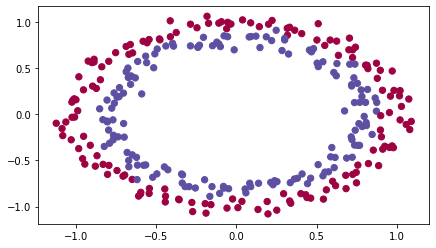

In [23]:
train_X, train_Y, test_X, test_Y = load_dataset()

#### 设置参数

In [24]:
layer_dims = [train_X.shape[0], 10, 5, 1]
print(layer_dims)

lr = 0.01
num_epochs = 15000
print_cost=True

[2, 10, 5, 1]


#### 正常初始化

parameters: 
 {'W1': array([[ 1.14858562, -0.43257711],
       [-0.37347383, -0.75870339],
       [ 0.6119356 , -1.62743362],
       [ 1.23376823, -0.53825456],
       [ 0.22559471, -0.17633148],
       [ 1.03386644, -1.45673947],
       [-0.22798339, -0.27156744],
       [ 0.80169606, -0.77774057],
       [-0.12192515, -0.62073964],
       [ 0.02984963,  0.41211259]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.34804634,  0.36199342,  0.28510802,  0.15890266,  0.28487566,
        -0.21621373, -0.0388613 , -0.29591628, -0.08471365,  0.16771312],
       [-0.21872233, -0.12546448, -0.21730309, -0.26727749, -0.21226666,
        -0.0040049 , -0.35332456,  0.07412875,  0.52487553,  0.23465497],
       [-0.06066373, -0.28069292, -0.2362722 ,  0.53520114,  0.01606682,
        -0.20143571,  0.06037278,  0.66415899,  0.0379976 ,  0.19517676],
       [ 0.09492219, -0.11139118, -0.36129

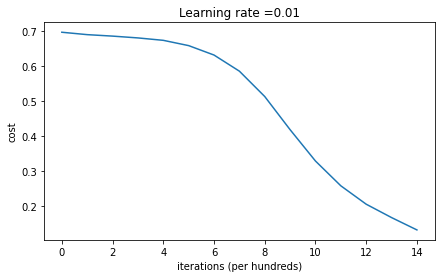

In [25]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost)
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

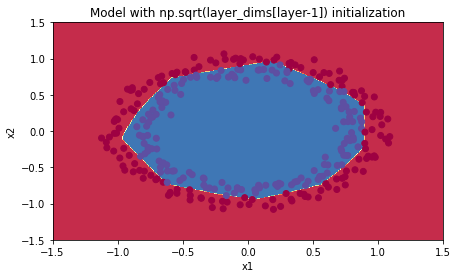

In [26]:
plt.title("Model with np.sqrt(layer_dims[layer-1]) initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

#### zero 初始化

parameters: 
 {'W1': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'b2': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W3': array([[0., 0., 0., 0., 0.]]), 'b3': array([[0.]])}
cost after epoch 0: 0.6931471805599453
cost after epoch 1000: 0.6931471805599453
cost after epoch 2000: 0.6931471805599453
cost after epoch 3000: 0.6931471805599453
cost after epoch 4000: 0.6931471805599453
cost after epoch 5000: 0.6931471805599453
cost after epoch 6000: 0.69314718055

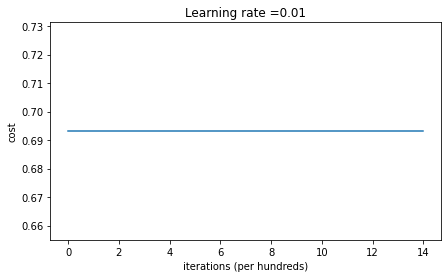

In [27]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost, initialization='zeros')
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

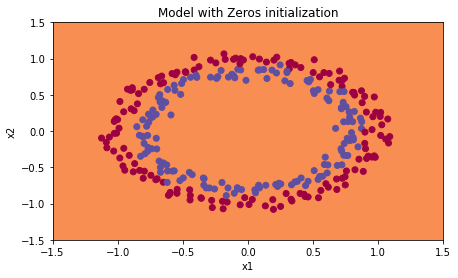

In [28]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

#### random 初始化

parameters: 
 {'W1': array([[ 17.88628473,   4.36509851],
       [  0.96497468, -18.63492703],
       [ -2.77388203,  -3.54758979],
       [ -0.82741481,  -6.27000677],
       [ -0.43818169,  -4.7721803 ],
       [-13.13864753,   8.8462238 ],
       [  8.81318042,  17.09573064],
       [  0.50033642,  -4.04677415],
       [ -5.45359948, -15.46477316],
       [  9.82367434, -11.0106763 ]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-11.85046527,  -2.05649899,  14.86148355,   2.36716267,
        -10.2378514 ,  -7.129932  ,   6.25244966,  -1.60513363,
         -7.6883635 ,  -2.30030722],
       [  7.45056266,  19.76110783, -12.44123329,  -6.26416911,
         -8.03766095, -24.19083173,  -9.23792022, -10.23875761,
         11.23977959,  -1.31914233],
       [-16.23285446,   6.46675452,  -3.56270759, -17.43141037,
         -5.96649642,  -5.8859438 ,  -8.73882298,   0.29713815,
     

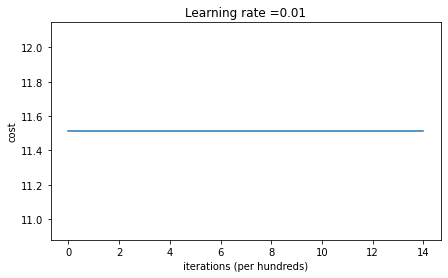

In [29]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost, initialization='random')
# print(parameters)
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

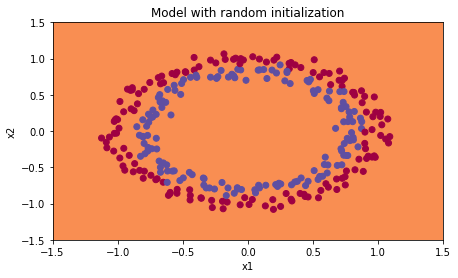

In [30]:
plt.title("Model with random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

<font color=red size=5>注意：</font>
* 这里训练不起来是因为参数随机初始化时，参数太大，导致wx+b很大或很少，在sigmoid计算时，处于梯度为0的情况下，导致参数没法更新，即梯度消失情况

#### he初始化

parameters: 
 {'W1': array([[ 1.78862847,  0.43650985],
       [ 0.09649747, -1.8634927 ],
       [-0.2773882 , -0.35475898],
       [-0.08274148, -0.62700068],
       [-0.04381817, -0.47721803],
       [-1.31386475,  0.88462238],
       [ 0.88131804,  1.70957306],
       [ 0.05003364, -0.40467741],
       [-0.54535995, -1.54647732],
       [ 0.98236743, -1.10106763]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.52996892, -0.09196943,  0.66462575,  0.10586273, -0.45785063,
        -0.31886025,  0.27961805, -0.07178376, -0.34383407, -0.10287287],
       [ 0.33319929,  0.88374361, -0.55638887, -0.28014216, -0.35945513,
        -1.08184688, -0.41313235, -0.45789116,  0.50265822, -0.05899384],
       [-0.72595532,  0.28920205, -0.15932913, -0.77955637, -0.26682983,
        -0.26322741, -0.39081204,  0.01328842, -1.00545144, -0.11974675],
       [ 0.45310941,  0.38138279,  0.49559

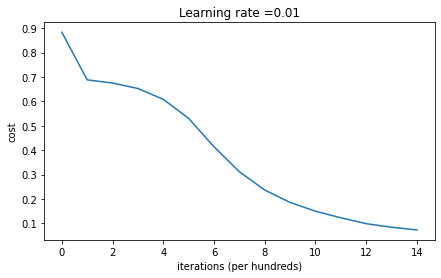

In [31]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost, initialization='he')
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

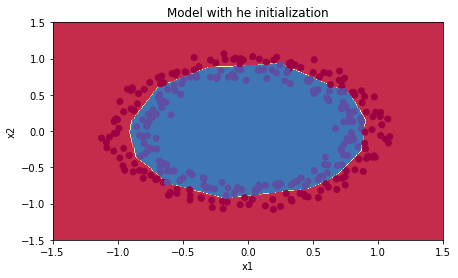

In [32]:
plt.title("Model with he initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

### <font color=red size=5>总结</font>

1. 不同的参数初始化导致不同的结果
2. 随机参数初始化是为了打破对称性以及确保各隐藏units可以学习不同的特征
3. 不要初始化太大的值，会导致梯度消失或者爆炸
4. 对于relu激活函数来说，he初始化方式能表现很好

## 通过`正则化`技巧提升dnn

Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!

### 1-L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

#### 1.1 overwrite compute cost

In [33]:
def func_compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    :param AL -- post-activation, output of forward propagation, of shape (output size, number of examples)
    :param Y -- "true" labels vector, of shape (output size, number of examples)
    :param parameters -- python dictionary containing parameters of the model
    :param lambd -- 正则系数
    :return:
        cost - value of the regularized loss function (formula (2))
    """
    cross_entropy_cost = func_compute_cost(AL, Y)
    
    m = Y.shape[1]
    L = len(parameters) // 2
    tmp = [parameters['W'+str(layer)] for layer in range(1, L+1)]
    
    L2_regularization_cost = sum([np.sum(np.square(w)) for w in tmp]) * lambd / 2 / m
    
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

In [34]:
def func_compute_cost_with_regularization_test_case():
    np.random.seed(1)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 2)
    b2 = np.random.randn(3, 1)
    W3 = np.random.randn(1, 3)
    b3 = np.random.randn(1, 1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    a3 = np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]])
    return a3, Y_assess, parameters

In [35]:
A3, Y_assess, parameters = func_compute_cost_with_regularization_test_case()

In [36]:
A3, Y_assess, parameters

(array([[0.40682402, 0.01629284, 0.16722898, 0.10118111, 0.40682402]]),
 array([[1, 1, 0, 1, 0]]),
 {'W1': array([[ 1.62434536, -0.61175641, -0.52817175],
         [-1.07296862,  0.86540763, -2.3015387 ]]),
  'b1': array([[ 1.74481176],
         [-0.7612069 ]]),
  'W2': array([[ 0.3190391 , -0.24937038],
         [ 1.46210794, -2.06014071],
         [-0.3224172 , -0.38405435]]),
  'b2': array([[ 1.13376944],
         [-1.09989127],
         [-0.17242821]]),
  'W3': array([[-0.87785842,  0.04221375,  0.58281521]]),
  'b3': array([[-1.10061918]])})

In [37]:
func_compute_cost_with_regularization(A3, Y_assess, parameters, lambd=0.1)

1.7864859451590758

#### 1.2 overwrite backward propagation

$$
\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W
$$

In [38]:
def func_linear_backward_with_regularization(dZ, cache, lambd):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    :param dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    :param cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    :param lambd -- 正则系数
    :return:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1 / m * np.dot(dZ, A_prev.T) + lambd / m * W
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)  # axis=1是行记录求和
    dA_prev = np.dot(W.T, dZ)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev, dW, db

def func_linear_activation_backward_with_regularization(dA, cache, lambd, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    :param dA -- post-activation gradient for current layer l 
    :param cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    :param lambd -- 正则系数
    :param activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    :returns
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = func_relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = func_sigmoid_backward(dA, activation_cache)
    else:
        raise ValueError('activation param')
    dA_prev, dW, db = func_linear_backward_with_regularization(dZ, linear_cache, lambd)
    return dA_prev, dW, db

def func_L_model_backward_with_regularization(AL, Y, caches, lambd):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    :param AL -- probability vector, output of the forward propagation (L_model_forward())
    :param Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    :param caches -- list of caches containing:
                    every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                    the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    :param lambd -- 正则系数
    :return:
        grads -- A dictionary with the gradients
                 grads["dA" + str(l)] = ... 
                 grads["dW" + str(l)] = ...
                 grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    cur_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = func_linear_activation_backward_with_regularization(dAL, cur_cache, lambd, activation='sigmoid')
    
    for layer in reversed(range(L-1)):
        cur_cache = caches[layer]
        dA_prev_tmp, dW_tmp, db_tmp = func_linear_activation_backward_with_regularization(grads["dA"+str(layer+1)], cur_cache, lambd, activation='relu')
        grads['dA'+str(layer)] = dA_prev_tmp
        grads['dW'+str(layer+1)] = dW_tmp
        grads['db'+str(layer+1)] = db_tmp
    
#     current_cache = caches[L-1]
#     grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = func_linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
#     for l in reversed(range(L-1)):
#         # lth layer: (RELU -> LINEAR) gradients.
#         current_cache = caches[l]
#         dA_prev_temp, dW_temp, db_temp = func_linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
#         grads["dA" + str(l + 1)] = dA_prev_temp
#         grads["dW" + str(l + 1)] = dW_temp
#         grads["db" + str(l + 1)] = db_temp
    
    return grads

In [39]:
def func_backward_propagation_with_regularization_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
         [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
  np.array([[ 0.        ,  3.32524635,  2.13994541,  2.60700654,  0.        ],
         [ 0.        ,  4.1600994 ,  0.79051021,  1.46493512,  0.        ]]),
  np.array([[-1.09989127, -0.17242821, -0.87785842],
         [ 0.04221375,  0.58281521, -1.10061918]]),
  np.array([[ 1.14472371],
         [ 0.90159072]]),
  np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [-0.69166075, -3.47645987, -2.25194702, -2.65416996, -0.69166075],
         [-0.39675353, -4.62285846, -2.61101729, -3.22874921, -0.39675353]]),
  np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
  np.array([[ 0.50249434,  0.90085595],
         [-0.68372786, -0.12289023],
         [-0.93576943, -0.26788808]]),
  np.array([[ 0.53035547],
         [-0.69166075],
         [-0.39675353]]),
  np.array([[-0.3771104 , -4.10060224, -1.60539468, -2.18416951, -0.3771104 ]]),
  np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]]),
  np.array([[-0.6871727 , -0.84520564, -0.67124613]]),
  np.array([[-0.0126646]]))
    return X_assess, Y_assess, cache

In [40]:
X_assess, Y_assess, cache = func_backward_propagation_with_regularization_test_case()

In [41]:
X_assess, Y_assess, cache

(array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
        [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
        [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
 array([[1, 1, 0, 1, 0]]),
 (array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
         [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
  array([[0.        , 3.32524635, 2.13994541, 2.60700654, 0.        ],
         [0.        , 4.1600994 , 0.79051021, 1.46493512, 0.        ]]),
  array([[-1.09989127, -0.17242821, -0.87785842],
         [ 0.04221375,  0.58281521, -1.10061918]]),
  array([[1.14472371],
         [0.90159072]]),
  array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [-0.69166075, -3.47645987, -2.25194702, -2.65416996, -0.69166075],
         [-0.39675353, -4.62285846, -2.61101729, -3.22874921, -0.39675353]]),
  array([[0.53035547, 5.94892323, 2.31780174, 3.16005701, 0.53035547

In [42]:
(Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

In [43]:
caches = [((X_assess, W1, b1), Z1), 
          ((A1, W2, b2), Z2), 
          ((A2, W3, b3), Z3)]

In [44]:
caches

[((array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
          [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
          [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
   array([[-1.09989127, -0.17242821, -0.87785842],
          [ 0.04221375,  0.58281521, -1.10061918]]),
   array([[1.14472371],
          [0.90159072]])),
  array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
         [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]])),
 ((array([[0.        , 3.32524635, 2.13994541, 2.60700654, 0.        ],
          [0.        , 4.1600994 , 0.79051021, 1.46493512, 0.        ]]),
   array([[ 0.50249434,  0.90085595],
          [-0.68372786, -0.12289023],
          [-0.93576943, -0.26788808]]),
   array([[ 0.53035547],
          [-0.69166075],
          [-0.39675353]])),
  array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [-0.69166075, -3.47645987, -2.25

In [45]:
grads = func_L_model_backward_with_regularization(A3, Y_assess, caches, lambd=0.7)

In [46]:
grads

{'dA2': array([[ 0.40761434,  0.67597688, -0.11491519,  0.61764379, -0.27955836],
        [ 0.50135568,  0.83143505, -0.14134288,  0.75968678, -0.34384996],
        [ 0.39816708,  0.66030979, -0.11225181,  0.60332869, -0.27307905]]),
 'dW3': array([[-1.77691375, -0.11832879, -0.09397446]]),
 'db3': array([[-0.38032985]]),
 'dA1': array([[ 0.2048239 ,  0.33967455, -0.05774423,  0.31036251, -0.14047649],
        [ 0.3672018 ,  0.60895779, -0.10352203,  0.55640808, -0.25184181]]),
 'dW2': array([[ 0.79276497,  0.85133932],
        [-0.0957219 , -0.01720463],
        [-0.13100772, -0.03750433]]),
 'db2': array([[0.26135229],
        [0.        ],
        [0.        ]]),
 'dA0': array([[ 0.        , -0.34789869,  0.05914233, -0.31787694,  0.        ],
        [ 0.        ,  0.29634039, -0.05037748,  0.27076784,  0.        ],
        [ 0.        , -0.96841679,  0.1646296 , -0.88484775,  0.        ]]),
 'dW1': array([[-0.25604647,  0.1229883 , -0.28297132],
        [-0.17706304,  0.345361  , 

### 2-dropout

详情如以下视频

<center>
<video width="620" height="440" src="./深度学习之吴恩达课程作业4/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Figure 2 </u>: Drop-out on the second hidden layer. <br> At each iteration, you shut down (= set to zero) each neuron of a layer with probability $1 - keep\_prob$ or keep it with probability $keep\_prob$ (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration. </center></caption>

<center>
<video width="620" height="440" src="./深度学习之吴恩达课程作业4/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Figure 3 </u>: Drop-out on the first and third hidden layers. <br> $1^{st}$ layer: we shut down on average 40% of the neurons.  $3^{rd}$ layer: we shut down on average 20% of the neurons. </center></caption>

<font color=red size=5>注意：</font>
1. 以`1-keep_prob`值丢弃units，则要将 Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

#### 2.1-overwrite forward propagation

In [47]:
def func_linear_forward(A, W, b):
    """
    linear forward
    :param A:
    :param W:
    :param b:
    :return Z,chche:
        Z -- the input of the activation function, also called pre-activation parameter 
        cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

def func_linear_activation_forward_with_dropout(A_prev, W, b, activation, keep_prob=None):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param A_prev: activations from previous layer (or input data): (size of previous layer, number of examples)
    :param W: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    :param b: bias vector, numpy array of shape (size of the current layer, 1)
    :param activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    :param keep_prob -- probability of keeping a neuron active during drop-out, scalar
    :return:
        A -- the output of the activation function, also called the post-activation value 
        cache -- a python dictionary containing "linear_cache" and "activation_cache";
                 stored for computing the backward pass efficiently
    """
    Z, linear_cache = func_linear_forward(A_prev, W, b)
    D = None
    if activation == 'sigmoid':
        A, activation_cache = func_sigmoid(Z)
    elif activation == 'relu':
        A, activation_cache = func_relu(Z)
        if keep_prob:
            D = np.random.rand(*A.shape)  # Step 1: initialize matrix D1 = np.random.rand(..., ...)
            D = D < keep_prob  # convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
            A = A * D  # shut down some neurons of A
            A = A / keep_prob  # scale the value of neurons that haven't been shut down
    else:
        raise ValueError('activation param')
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache, D)
    return A, cache

def func_L_model_forward_with_dropout(X, parameters, keep_prob=0.5):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    :param X -- data, numpy array of shape (input size, number of examples)
    :param parameters -- output of initialize_parameters_deep()
    :param keep_prob -- probability of keeping a neuron active during drop-out, scalar
    :return:
        AL -- last post-activation value
        caches -- list of caches containing:
                    every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                    the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    np.random.seed(1)
    caches = []
    A = X
    L = len(parameters) // 2
    
    for layer in range(1, L):
        A_prev = A
        W, b = parameters['W'+str(layer)], parameters['b'+str(layer)]
        A, cache = func_linear_activation_forward_with_dropout(A_prev, W, b, 'relu', keep_prob)
        caches.append(cache)
    
    A_prev = A
    layer = L
    W, b = parameters['W'+str(layer)], parameters['b'+str(layer)]
    A, cache = func_linear_activation_forward_with_dropout(A_prev, W, b, 'sigmoid')
    caches.append(cache)
    
    assert(A.shape == (1, X.shape[1]))
    return A, caches

In [48]:
def func_forward_propagation_with_dropout_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 2)
    b2 = np.random.randn(3, 1)
    W3 = np.random.randn(1, 3)
    b3 = np.random.randn(1, 1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    return X_assess, parameters

In [49]:
X_assess, parameters = func_forward_propagation_with_dropout_test_case()

In [50]:
X_assess, parameters

(array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
        [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
        [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
 {'W1': array([[-1.09989127, -0.17242821, -0.87785842],
         [ 0.04221375,  0.58281521, -1.10061918]]),
  'b1': array([[1.14472371],
         [0.90159072]]),
  'W2': array([[ 0.50249434,  0.90085595],
         [-0.68372786, -0.12289023],
         [-0.93576943, -0.26788808]]),
  'b2': array([[ 0.53035547],
         [-0.69166075],
         [-0.39675353]]),
  'W3': array([[-0.6871727 , -0.84520564, -0.67124613]]),
  'b3': array([[-0.0126646]])})

In [51]:
AL, caches = func_L_model_forward_with_dropout(X_assess, parameters, keep_prob=0.7)

In [52]:
AL, caches

(array([[0.36974721, 0.00305176, 0.04565099, 0.49683389, 0.36974721]]),
 [((array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
           [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
           [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
    array([[-1.09989127, -0.17242821, -0.87785842],
           [ 0.04221375,  0.58281521, -1.10061918]]),
    array([[1.14472371],
           [0.90159072]])),
   array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
          [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
   array([[ True, False,  True,  True,  True],
          [ True,  True,  True,  True,  True]])),
  ((array([[0.        , 0.        , 3.05706487, 3.72429505, 0.        ],
           [0.        , 5.94299915, 1.1293003 , 2.09276446, 0.        ]]),
    array([[ 0.50249434,  0.90085595],
           [-0.68372786, -0.12289023],
           [-0.93576943, -0.26788808]]),
    array([[ 

#### 2.2 overwrite backward propagation

1. You had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, you had divided `A1` by `keep_prob`. In backpropagation, you'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).


In [53]:
def func_linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    :param dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    :param cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    :return:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)  # axis=1是行记录求和
    dA_prev = np.dot(W.T, dZ)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev, dW, db

def func_linear_activation_backward_with_dropout(dA, cache, activation, keep_prob=None):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    :param dA -- post-activation gradient for current layer l 
    :param cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    :param activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    :param keep_prob -- 保留neuron的比例
    :returns
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache, D = cache
    
    if activation == 'relu':
        if keep_prob and D is not None:
            dA = dA * D  # shut down some neurons of A
            dA = dA / keep_prob  # scale the value of neurons that haven't been shut down
        dZ = func_relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = func_sigmoid_backward(dA, activation_cache)
    else:
        raise ValueError('activation param')
    dA_prev, dW, db = func_linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def func_L_model_backward_with_dropout(AL, Y, caches, keep_prob):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    :param AL -- probability vector, output of the forward propagation (L_model_forward())
    :param Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    :param caches -- list of caches containing:
                    every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                    the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    :param keep_prob -- 保留neuron的比例
    :return:
        grads -- A dictionary with the gradients
                 grads["dA" + str(l)] = ... 
                 grads["dW" + str(l)] = ...
                 grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # todo divide by zero encountered in true_divide
    dAL = - (np.divide(Y, AL, where=AL!=0) - np.divide(1-Y, 1-AL, where=(1-AL)!=0))
    
    cur_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = func_linear_activation_backward_with_dropout(dAL, cur_cache, activation='sigmoid')
    
    for layer in reversed(range(L-1)):
        cur_cache = caches[layer]
        dA_prev_tmp, dW_tmp, db_tmp = func_linear_activation_backward_with_dropout(grads["dA"+str(layer+1)], cur_cache, activation='relu', keep_prob=keep_prob)
        grads['dA'+str(layer)] = dA_prev_tmp
        grads['dW'+str(layer+1)] = dW_tmp
        grads['db'+str(layer+1)] = db_tmp
    
#     current_cache = caches[L-1]
#     grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = func_linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
#     for l in reversed(range(L-1)):
#         # lth layer: (RELU -> LINEAR) gradients.
#         current_cache = caches[l]
#         dA_prev_temp, dW_temp, db_temp = func_linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
#         grads["dA" + str(l + 1)] = dA_prev_temp
#         grads["dW" + str(l + 1)] = dW_temp
#         grads["db" + str(l + 1)] = db_temp
    
    return grads

In [54]:
def func_backward_propagation_with_dropout_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
           [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]), np.array([[ True, False,  True,  True,  True],
           [ True,  True,  True,  True, False]], dtype=bool), np.array([[ 0.        ,  0.        ,  4.27989081,  5.21401307,  0.        ],
           [ 0.        ,  8.32019881,  1.58102041,  2.92987024,  0.        ]]), np.array([[-1.09989127, -0.17242821, -0.87785842],
           [ 0.04221375,  0.58281521, -1.10061918]]), np.array([[ 1.14472371],
           [ 0.90159072]]), np.array([[ 0.53035547,  8.02565606,  4.10524802,  5.78975856,  0.53035547],
           [-0.69166075, -1.71413186, -3.81223329, -4.61667916, -0.69166075],
           [-0.39675353, -2.62563561, -4.82528105, -6.0607449 , -0.39675353]]), np.array([[ True, False,  True, False,  True],
           [False,  True, False,  True,  True],
           [False, False,  True, False, False]], dtype=bool), np.array([[ 1.06071093,  0.        ,  8.21049603,  0.        ,  1.06071093],
           [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]), np.array([[ 0.50249434,  0.90085595],
           [-0.68372786, -0.12289023],
           [-0.93576943, -0.26788808]]), np.array([[ 0.53035547],
           [-0.69166075],
           [-0.39675353]]), np.array([[-0.7415562 , -0.0126646 , -5.65469333, -0.0126646 , -0.7415562 ]]), np.array([[ 0.32266394,  0.49683389,  0.00348883,  0.49683389,  0.32266394]]), np.array([[-0.6871727 , -0.84520564, -0.67124613]]), np.array([[-0.0126646]]))


    return X_assess, Y_assess, cache

In [55]:
X_assess, Y_assess, cache = func_backward_propagation_with_dropout_test_case()

In [56]:
(Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

In [57]:
caches = [((X_assess, W1, b1), Z1, D1), 
          ((A1, W2, b2), Z2, D2), 
          ((A2, W3, b3), Z3, None)]

In [58]:
grads = func_L_model_backward_with_dropout(A3, Y_assess, caches, keep_prob=0.8)

In [59]:
grads

{'dA2': array([[ 0.46544685,  0.34576201, -0.00239743,  0.34576201, -0.22172585],
        [ 0.57248826,  0.42527883, -0.00294878,  0.42527883, -0.27271738],
        [ 0.45465921,  0.3377483 , -0.00234186,  0.3377483 , -0.21658692]]),
 'dW3': array([[-0.06951191,  0.        ,  0.        ]]),
 'db3': array([[-0.2715031]]),
 'dA1': array([[ 0.29235551,  0.        , -0.00150587,  0.        , -0.13926998],
        [ 0.5241257 ,  0.        , -0.00269967,  0.        , -0.24967881]]),
 'dW2': array([[-0.00256518, -0.0009476 ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]),
 'db2': array([[0.06033089],
        [0.        ],
        [0.        ]]),
 'dA0': array([[ 0.        ,  0.        ,  0.00192791,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.0016422 ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00536657,  0.        ,  0.        ]]),
 'dW1': array([[0.00019884, 0.00028657, 0.00012138],
        [0.00035647, 0.00051375, 0.0002

In [60]:
grads['dA2'] * D2 / 0.8

array([[ 0.58180856,  0.        , -0.00299679,  0.        , -0.27715731],
       [ 0.        ,  0.53159854, -0.        ,  0.53159854, -0.34089673],
       [ 0.        ,  0.        , -0.00292733,  0.        , -0.        ]])

In [61]:
grads['dA1'] * D1 / 0.8

array([[ 0.36544439,  0.        , -0.00188234,  0.        , -0.17408748],
       [ 0.65515713,  0.        , -0.00337459,  0.        , -0.        ]])

### overwrite dnn model

In [62]:
def func_L_layer_dnn_model(X, Y, layer_dims, lr=0.3, num_epochs=30000, print_cost=True, lambd=0, keep_prob=1):
    """
    多层神经网络模型
    :param X:
    :param Y:
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :param lr: learning rate
    :param num_epochs:
    :param print_cost:
    :param lambd: regularilization parameters
    :param keep_prob: dropout keep prob
    
    :return params
    """
#     np.random.seed(1)
    costs = []
    grads = {}
#     m = X.shape[1]
    
    # 参数初始化
    parameters = func_L_layers_initialize_parameters(layer_dims, seed=3)
    
    # loop
    for epoch in range(num_epochs):
        # 前向传播
        if keep_prob == 1:
            AL, caches = func_L_model_forward(X, parameters)
        elif keep_prob < 1:
            AL, caches = func_L_model_forward_with_dropout(X, parameters, keep_prob)
        
        # 计算损失
        if lambd == 0:
            cost = func_compute_cost(AL, Y)
        else:
            cost = func_compute_cost_with_regularization(AL, Y, parameters, lambd)
        
        # 后向传播
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = func_L_model_backward(AL, Y, caches)
        elif lambd != 0:
            grads = func_L_model_backward_with_regularization(AL, Y, caches, lambd)
        elif keep_prob < 1:
            grads = func_L_model_backward_with_dropout(AL, Y, caches, keep_prob)

        # 更新参数
        parameters = func_update_parameters(parameters, grads, lr)
        
        # 打印信息
        if print_cost and epoch % 1000 == 0:
            print('cost after epoch {}: {}'.format(epoch, np.squeeze(cost)))
        if epoch % 1000 == 0:
            costs.append(cost)
    
    return parameters, costs

### 在模拟数据上训练
#### 导入数据

In [63]:
def load_2D_dataset():
    data = scipy.io.loadmat('./深度学习之吴恩达课程作业4/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

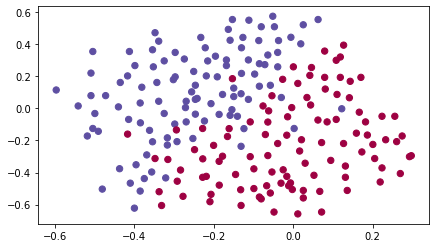

In [64]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

#### 设置参数

In [65]:
layer_dims = [train_X.shape[0], 20, 3, 1]
print(layer_dims)

lr = 0.3
num_epochs = 30000
print_cost=True

lambd = 0
keep_prob=1

[2, 20, 3, 1]


#### baseline model: 没有任何正则化手段的模型

cost after epoch 0: 0.6557412523481002
cost after epoch 1000: 0.2222669386845115
cost after epoch 2000: 0.20288702607598844
cost after epoch 3000: 0.1825149792468696
cost after epoch 4000: 0.18053978306217752
cost after epoch 5000: 0.17620471758400458
cost after epoch 6000: 0.1683273039211542
cost after epoch 7000: 0.16583593654672965
cost after epoch 8000: 0.163126719144605
cost after epoch 9000: 0.15942612253245111
cost after epoch 10000: 0.16329987525724202
cost after epoch 11000: 0.16098614487789192
cost after epoch 12000: 0.15764474148192972
cost after epoch 13000: 0.15213599644222855
cost after epoch 14000: 0.14843713518977336
cost after epoch 15000: 0.1479640092257416
cost after epoch 16000: 0.1463487630634997
cost after epoch 17000: 0.14634375863077015
cost after epoch 18000: 0.1433508853738097
cost after epoch 19000: 0.13936488362305466
cost after epoch 20000: 0.13851642423258528
cost after epoch 21000: 0.14118678351792227
cost after epoch 22000: 0.13629319468823384
cost after

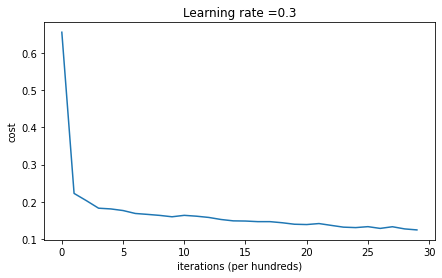

In [66]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost, lambd=lambd, keep_prob=keep_prob)
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

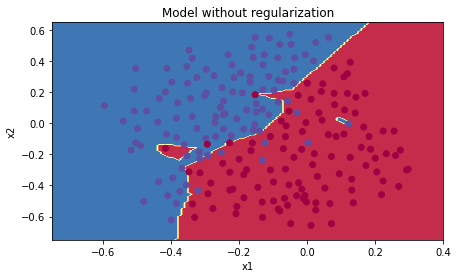

In [67]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

#### L2 regularization model

In [68]:
layer_dims = [train_X.shape[0], 20, 3, 1]
print(layer_dims)

lr = 0.3
num_epochs = 30000
print_cost=True

lambd = 0.7
keep_prob=1

[2, 20, 3, 1]


cost after epoch 0: 0.6974484493131264
cost after epoch 1000: 0.27304563479326766
cost after epoch 2000: 0.26985760798332925
cost after epoch 3000: 0.269508280641266
cost after epoch 4000: 0.26926544493616217
cost after epoch 5000: 0.2690430474349705
cost after epoch 6000: 0.26889745607345616
cost after epoch 7000: 0.26877517178557253
cost after epoch 8000: 0.26867325020602606
cost after epoch 9000: 0.2685595174585008
cost after epoch 10000: 0.2684918873282239
cost after epoch 11000: 0.2684141282822975
cost after epoch 12000: 0.268370115369031
cost after epoch 13000: 0.2683177401855035
cost after epoch 14000: 0.26826704893477976
cost after epoch 15000: 0.2682199033729047
cost after epoch 16000: 0.2681687054797271
cost after epoch 17000: 0.2681517100224052
cost after epoch 18000: 0.2681331699914915
cost after epoch 19000: 0.2680892379993576
cost after epoch 20000: 0.26809163371273015
cost after epoch 21000: 0.26803821899502356
cost after epoch 22000: 0.26806045797644007
cost after epoch

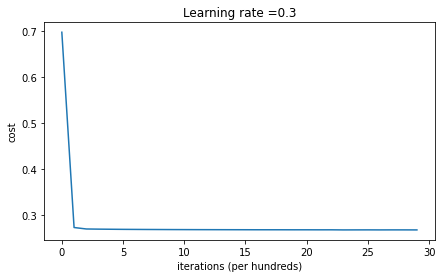

In [69]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost, lambd=lambd, keep_prob=keep_prob)
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

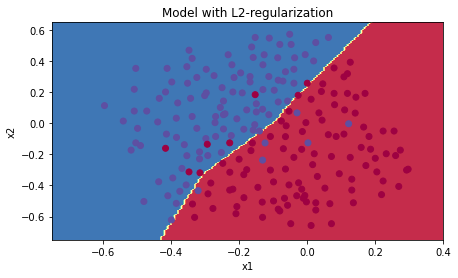

In [70]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

#### dropout model

In [71]:
layer_dims = [train_X.shape[0], 20, 3, 1]
print(layer_dims)

lr = 0.3
num_epochs = 30000
print_cost=True

lambd = 0
keep_prob=0.86

[2, 20, 3, 1]


cost after epoch 0: 0.6543912405149825
cost after epoch 1000: 0.1759784892976791
cost after epoch 2000: 0.10396707442944592
cost after epoch 3000: 0.07661297787708934
cost after epoch 4000: 0.06719891270763614
cost after epoch 5000: 0.06466905010089666
cost after epoch 6000: 0.06240987262093488
cost after epoch 7000: 0.0618787353396944
cost after epoch 8000: 0.06143321818157481
cost after epoch 9000: 0.06119214378902588
cost after epoch 10000: 0.06101698660803223
cost after epoch 11000: 0.06093245086027745
cost after epoch 12000: 0.06082640200152239
cost after epoch 13000: 0.060862641336133956
cost after epoch 14000: 0.06083521540719877
cost after epoch 15000: 0.0606645721999514
cost after epoch 16000: 0.06064947241699113
cost after epoch 17000: 0.0606258566616184
cost after epoch 18000: 0.060658745096947145
cost after epoch 19000: 0.06059651334487958
cost after epoch 20000: 0.060582435841229895
cost after epoch 21000: 0.06055919942402353
cost after epoch 22000: 0.06057898394513002
cos

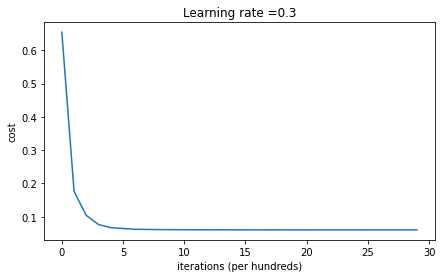

In [72]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost, lambd=lambd, keep_prob=keep_prob)
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

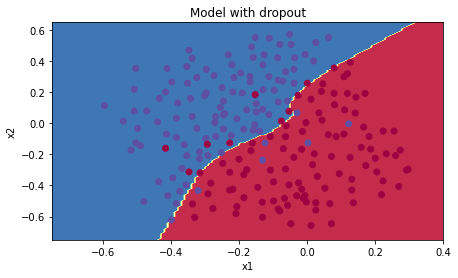

In [73]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

### <font color=red size=5>总结</font>

Note that regularization hurts training set performance! This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping your system. 

## 梯度检验

* 检查反向传播过程是否正确？则需要梯度检验

### 工作原理介绍

1. 确保你的前向传播和计算loss完全正确！
2. 检验反向传播过程，也就是检查$\frac{\partial J}{\partial \theta}$是否计算正确
3. 回顾导数的定义

$$
\frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon}
$$

* 则可以使用$J(\theta + \varepsilon)$ and $J(\theta - \varepsilon)$ (in the case that $\theta$ is a real number), since you're confident your implementation for $J$ is correct

### 1D 梯度检验

#### 步骤
 To show that the `func_1d_backward_propagation()` function is correctly computing the gradient $\frac{\partial J}{\partial \theta}$, let's implement gradient checking.

- First compute "gradapprox" using the formula above (1) and a small value of $\varepsilon$. Here are the Steps to follow:
    1. $\theta^{+} = \theta + \varepsilon$
    2. $\theta^{-} = \theta - \varepsilon$
    3. $J^{+} = J(\theta^{+})$
    4. $J^{-} = J(\theta^{-})$
    5. $gradapprox = \frac{J^{+} - J^{-}}{2  \varepsilon}$
- Then compute the gradient using backward propagation, and store the result in a variable "grad"
- Finally, compute the relative difference between "gradapprox" and the "grad" using the following formula:
$$ difference = \frac {\mid\mid grad - gradapprox \mid\mid_2}{\mid\mid grad \mid\mid_2 + \mid\mid gradapprox \mid\mid_2} \tag{2}$$
You will need 3 Steps to compute this formula:
   - 1'. compute the numerator using np.linalg.norm(...)
   - 2'. compute the denominator. You will need to call np.linalg.norm(...) twice.
   - 3'. divide them.
- If this difference is small (say less than $10^{-7}$), you can be quite confident that you have computed your gradient correctly. Otherwise, there may be a mistake in the gradient computation. 


In [74]:
def func_1d_forward_propagation(x, theta):
    """
    Implement the linear forward propagation (compute J) presented in Figure 1 (J(theta) = theta * x)
    
    Arguments:
    x -- a real-valued input
    theta -- our parameter, a real number as well
    
    Returns:
    J -- the value of function J, computed using the formula J(theta) = theta * x
    """
    return theta * x

In [75]:
x, theta = 2, 4
J = func_1d_forward_propagation(x, theta)
print(J)

8


In [76]:
def func_1d_backward_propagation(x, theta):
    dtheta = x
    return dtheta

In [77]:
dtheta = func_1d_backward_propagation(x, theta)
print(dtheta)

2


In [78]:
def func_1d_gradient_check(x, theta, epsilon=1e-7):
    """
    Implement the backward propagation presented in Figure 1.
    
    Arguments:
    x -- a real-valued input
    theta -- our parameter, a real number as well
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)
    
    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """
    theta_plus = theta + epsilon
    theta_minus = theta - epsilon
    
    J_plus = func_1d_forward_propagation(x, theta_plus)
    J_minus = func_1d_forward_propagation(x, theta_minus)
    
    grad_approx = (J_plus - J_minus) / 2 / epsilon
    
    grad = func_1d_backward_propagation(x, theta)
    
    numerator = np.linalg.norm(grad - grad_approx)
    denominator = np.linalg.norm(grad) + np.linalg.norm(grad_approx)
    difference = numerator / denominator
    
    if difference < 1e-7:
        print('the gradient is correct!')
    else:
        print('the gradient is wrong!')
    return difference

In [79]:
difference = func_1d_gradient_check(x, theta)
difference

the gradient is correct!


2.919335883291695e-10

### N-dimensional gradient checking

#### check function=自己写的

In [80]:
def func_nd_gradient_check(parameters, gradients, X, Y, epsilon=1e-7):
    """
    Checks if backward_propagation_n computes correctly the gradient of the cost output by forward_propagation_n
    
    Arguments:
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
    grad -- output of backward_propagation_n, contains gradients of the cost with respect to the parameters. 
    x -- input datapoint, of shape (input size, 1)
    y -- true "label"
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)
    
    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """
    
    gradients_approx = {}
    
    for key, value in parameters.items():
#         print(key)
        parameters_copy = copy.copy(parameters)
        
        value_shape = value.shape  # w参数的规模
        value_vector = np.reshape(value, (-1, 1))  # 将w展开成(n_w, 1)
#         print(value_vector.shape, value_shape)
        gradapprox_vector = np.zeros((value_vector.shape[0], 1))  # 每改变一个w，对应一个gradapprox
        for i in range(value_vector.shape[0]):  # 每个w过一遍
            theta_plus = np.copy(value_vector)
            theta_plus[i][0] = theta_plus[i][0] + epsilon
            parameters_copy[key] = theta_plus.reshape(value_shape)
    #         print(parameters_copy)
            AL, _ = func_L_model_forward(X, parameters_copy)
            cost_plus = func_compute_cost(AL, Y)

            theta_minus = np.copy(value_vector)
            theta_minus[i][0] = theta_minus[i][0] - epsilon
            parameters_copy[key] = theta_minus.reshape(value_shape)
            AL, _ = func_L_model_forward(X, parameters_copy)
            cost_minus = func_compute_cost(AL, Y)
            
            gradapprox_vector[i] = (cost_plus - cost_minus) / 2 / epsilon
#         print(gradapprox_vector, gradapprox_vector.shape)
        gradients_approx['d'+key] = gradapprox_vector.reshape(value_shape)
    
    
    # 将gradients转成vector
    count = 0
    for key in gradients_approx.keys():
#         print(key)
        new_vector = np.reshape(gradients[key], (-1, 1))
        new_vector_approx = np.reshape(gradients_approx[key], (-1, 1))
        
        if count == 0:
            theta = new_vector
            theta_approx = new_vector_approx
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
            theta_approx = np.concatenate((theta_approx, new_vector_approx), axis=0)
        count += 1
    
    # 计算difference
#     print(theta.shape, theta_approx.shape)
#     print(theta, theta_approx)
    numerator = np.linalg.norm(theta - theta_approx)
    denominator = np.linalg.norm(theta) + np.linalg.norm(theta_approx)
#     print(numerator, denominator)
#     print(np.linalg.norm(theta), np.linalg.norm(theta_approx))
    difference = numerator / denominator
    
    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

#### 测试用的

In [81]:
def dictionary_to_vector(parameters):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    keys = []
    count = 0
    for key in ["W1", "b1", "W2", "b2", "W3", "b3"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

In [82]:
def vector_to_dictionary(theta):
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    """
    parameters = {}
    parameters["W1"] = theta[:20].reshape((10,2))
    parameters["b1"] = theta[20:30].reshape((10,1))
    parameters["W2"] = theta[30:80].reshape((5,10))
    parameters["b2"] = theta[80:85].reshape((5,1))
    parameters["W3"] = theta[85:90].reshape((1,5))
    parameters["b3"] = theta[90:91].reshape((1,1))

    return parameters

In [83]:
def gradients_to_vector(gradients):
    """
    Roll all our gradients dictionary into a single vector satisfying our specific required shape.
    """
    
    count = 0
    for key in ["dW1", "db1", "dW2", "db2", "dW3", "db3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

In [84]:
# GRADED FUNCTION: gradient_check_n

def gradient_check_n(parameters, gradients, X, Y, epsilon = 1e-7):
    """
    Checks if backward_propagation_n computes correctly the gradient of the cost output by forward_propagation_n
    
    Arguments:
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
    grad -- output of backward_propagation_n, contains gradients of the cost with respect to the parameters. 
    x -- input datapoint, of shape (input size, 1)
    y -- true "label"
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)
    
    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """
    
    # Set-up variables
    parameters_values, _ = dictionary_to_vector(parameters)
    grad = gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute gradapprox
    for i in range(num_parameters):
        
        # Compute J_plus[i]. Inputs: "parameters_values, epsilon". Output = "J_plus[i]".
        # "_" is used because the function you have to outputs two parameters but we only care about the first one
        ### START CODE HERE ### (approx. 3 lines)
        thetaplus = np.copy(parameters_values)                                      # Step 1
        thetaplus[i][0] += epsilon                                # Step 2
        AL, _ = func_L_model_forward(X, vector_to_dictionary( thetaplus  ))
        J_plus[i] = func_compute_cost(AL, Y)
#         J_plus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary( thetaplus  ))                                   # Step 3
        ### END CODE HERE ###
        
        # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".
        ### START CODE HERE ### (approx. 3 lines)
        thetaminus = np.copy(parameters_values)                                     # Step 1
        thetaminus[i][0] -= epsilon                               # Step 2        
        AL, _ = func_L_model_forward(X, vector_to_dictionary( thetaminus  ))
        J_minus[i] = func_compute_cost(AL, Y)
#         J_minus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary( thetaminus  ))                                  # Step 3
        ### END CODE HERE ###
        
        # Compute gradapprox[i]
        ### START CODE HERE ### (approx. 1 line)
        gradapprox[i] = (J_plus[i] - J_minus[i]) / 2/ epsilon
        ### END CODE HERE ###
    
    # Compare gradapprox to backward propagation gradients by computing difference.
    ### START CODE HERE ### (approx. 1 line)
    numerator = np.linalg.norm(grad - gradapprox)                               # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                                         # Step 2'
#     print(numerator, denominator)
#     print(grad, gradapprox)
    difference = numerator / denominator                                          # Step 3'
    ### END CODE HERE ###

    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

#### overwrite dnn model

In [85]:
def func_L_layer_dnn_model(X, Y, layer_dims, lr=0.001, num_epochs=10000, print_cost=False):
    """
    多层神经网络模型
    :param X:
    :param Y:
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :param lr: learning rate
    :param num_epochs:
    :param print_cost:
    :return params
    """
    np.random.seed(1)
    costs = []
#     m = X.shape[1]
    
    # 参数初始化
    parameters = func_L_layers_initialize_parameters(layer_dims)
    
    # loop
    for epoch in range(num_epochs):
        # 前向传播
        AL, caches = func_L_model_forward(X, parameters)
        
        # 计算损失
        cost = func_compute_cost(AL, Y)
        
        # 后向传播
        grads = func_L_model_backward(AL, Y, caches)
        
        if epoch == num_epochs-1:
            # 梯度检验
            # print(grads, caches)
            difference = func_nd_gradient_check(parameters, grads, X, Y)
            difference = gradient_check_n(parameters, grads, X, Y)
        

        # 更新参数
        parameters = func_update_parameters(parameters, grads, lr)
        
        # 打印信息
        if print_cost and epoch % 100 == 0:
            print('cost after epoch {}: {}'.format(epoch, np.squeeze(cost)))
        if epoch % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

#### 在模拟数据上训练
##### 导入数据

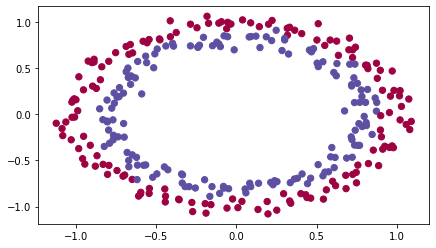

In [86]:
train_X, train_Y, test_X, test_Y = load_dataset()

##### 参数设置

In [87]:
layer_dims = [train_X.shape[0], 10, 5, 1]
print(layer_dims)

lr = 0.1
num_epochs = 1500
print_cost=True

[2, 10, 5, 1]


cost after epoch 0: 0.6960659020466242
cost after epoch 100: 0.6891991419051238
cost after epoch 200: 0.6850092483958543
cost after epoch 300: 0.6798479812645738
cost after epoch 400: 0.6729753561826027
cost after epoch 500: 0.6580667774079205
cost after epoch 600: 0.6311404895208866
cost after epoch 700: 0.5853323852501582
cost after epoch 800: 0.5132274924019706
cost after epoch 900: 0.41849780592362346
cost after epoch 1000: 0.3288154213170582
cost after epoch 1100: 0.2578987108855108
cost after epoch 1200: 0.20516738899849638
cost after epoch 1300: 0.16682454264195795
cost after epoch 1400: 0.13371779611157564
Your backward propagation works perfectly fine! difference = 1.0610826936117557e-08
Your backward propagation works perfectly fine! difference = 1.0610826936117557e-08
on the train set:
acc: 0.99
on the test set:
acc: 0.94


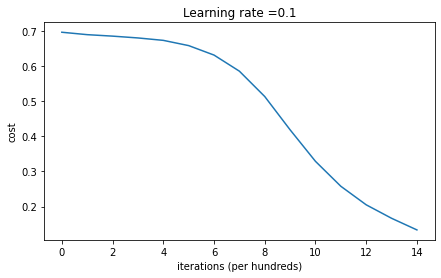

In [88]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, lr, num_epochs, print_cost)
print('on the train set:')
pred_train = func_predict(train_X, train_Y, parameters)
print('on the test set:')
pred_test = func_predict(test_X, test_Y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(lr))
plt.show()

In [89]:
for key, value in parameters.items():
    print(key, value.shape)

W1 (10, 2)
b1 (10, 1)
W2 (5, 10)
b2 (5, 1)
W3 (1, 5)
b3 (1, 1)


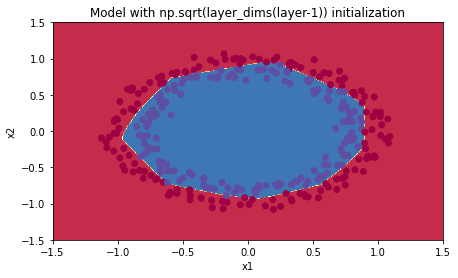

In [90]:
plt.title("Model with np.sqrt(layer_dims(layer-1)) initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

### <font color=red size=5>总结</font>

1. 梯度检验很慢，因为每一个w的分量都要计算plus和minus，所以不用每一个epoch都梯度检验，只需要某些epoch进行检验梯度计算是否正确即可
2. 梯度检验不适用于dropout，先检验是否正确，再加dropout